# ChemWalker Benchmark 

In [1]:
import pandas as pd
import collections
import time
from chemwalker.rwalker import *
from chemwalker.gnps import Proteosafe
from rdkit import Chem
import json
import os
import requests
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import collections

from ks import *

plt.style.use('ggplot')

Load benchmark data from [NAP](https://doi.org/10.1371/journal.pcbi.1006089) to compare to ChemWlaker.

In [3]:
val = pd.read_csv('data/pcbi.1006089.s007.tsv', sep='\t')
val.head()

,cluster.index,MetFrag,Random,Fusion,Consensus,Processing batch,parent.mass,LibraryID,INCHI,Smiles,...,Fusion group,Consensus group,Random group,True group,Processing batch.1,kingdom_name,superclass_name,class_name,NISTID,Original InChIKey
0,1,8,2,3,9,1,319.086,"2-((4,6-Dimethyl-2-pyrimidinyl)thio)-N-(3-nitr...",InChI=1S/C14H14N4O3S/c1-9-6-10(2)16-14(15-9)22...,CC1=CC(=NC(=N1)SCC(=O)NC2=CC(=CC=C2)[N+](=O)[O...,...,3,3,1,3,1,Organic compounds,Benzenoids,Benzene and substituted derivatives,1000076,VYSKBXGIMJYMOB-UHFFFAOYSA-N
1,2,1,1,1,5,1,362.053,N-(3-Nitrophenyl)-2-((4-methyl-5-(trifluoromet...,"InChI=1S/C12H10F3N5O3S/c1-19-10(12(13,14)15)17...",CN1C(=NN=C1SCC(=O)NC2=CC(=CC=C2)[N+](=O)[O-])C...,...,2,2,1,2,1,Organic compounds,Benzenoids,Benzene and substituted derivatives,1000077,VMCOPZWSRZZIJC-UHFFFAOYSA-N
2,3,1,1,1,2,1,311.027,"N-(3-Nitrophenyl)-2-((5-methyl-1,3,4-thiadiazo...",InChI=1S/C11H10N4O3S2/c1-7-13-14-11(20-7)19-6-...,CC1=NN=C(S1)SCC(=O)NC2=CC(=CC=C2)[N+](=O)[O-],...,2,2,2,2,1,Organic compounds,Benzenoids,Benzene and substituted derivatives,1000078,ZTEXJNMABIVJFD-UHFFFAOYSA-N
3,5,25,1,7,15,1,310.216,Methadone,InChI=1S/C21H27NO/c1-5-20(23)21(16-17(2)22(3)4...,CCC(=O)C(CC(C)N(C)C)(C1=CC=CC=C1)C2=CC=CC=C2,...,2,1,2,2,1,Organic compounds,Phenylpropanoids and polyketides,Flavonoids,1001496,USSIQXCVUWKGNF-UHFFFAOYSA-N
4,6,13,9,6,12,1,212.128,Methoxamine,InChI=1S/C11H17NO3/c1-7(12)11(13)9-6-8(14-2)4-...,CC(C(C1=C(C=CC(=C1)OC)OC)O)N,...,4,4,1,2,1,Organic compounds,Benzenoids,Benzene and substituted derivatives,1006296,WJAJPNHVVFWKKL-UHFFFAOYSA-N


In [14]:
val.shape

(5467, 25)

In order do validate ChemWalker, we used the 'Batch 1' from NAP's validation.

In [37]:
val['Processing batch.1'].value_counts()

8     571
3     568
5     560
2     559
1     555
9     553
4     552
6     530
10    510
7     509
Name: Processing batch.1, dtype: int64

Unzip and load the results from ChemWalker validation, by component and by fingerprint.

In [7]:
!unzip data/large_result_restart_0.5.zip

Archive:  data/large_result_restart_0.5.zip
   creating: large_result_restart_0.5/
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_63_AP-bits.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_41_RDKit5.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_77_MFP0-bits.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_96_FeatMFP1.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_43_RDKit6.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_74_FeatMFP0.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_71_RDKit5-linear.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_3_Avalon-512.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_89_RDKit7-linear.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_84_RDKit5-linear.json  
  inf

  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_63_FeatMFP0.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_73_FeatMFP2.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_58_Avalon-1024.json  
 extracting: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_76_RDKit6-linear.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_22_RDKit7.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_71_Avalon-512.json  
 extracting: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_55_RDKit7.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_22_FeatMFP3.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_2_RDKit7.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_54_MACCS.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_38_TT.json  
  inflating: lar

  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_46_AP.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_46_TT-bits.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_45_MFP1-bits.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_39_AP-bits.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_75_MACCS.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_64_MACCS.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_39_RDKit7.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_48_Avalon-512.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_79_MFP3.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_96_Avalon-512.json  
  inflating: large_result_restart_0.5/29d517e67067476bae97a32f2d4977e0_66_MFP1-bits.json  
  inflating: large_resul

In [38]:
df_list = []
fls = os.listdir('large_result_restart_0.5')
for fl in fls:
    with open(os.path.join('large_result_restart_0.5/', fl)) as f:
        try:
            tmp = json.loads(json.load(f))
        except:
            continue
        tmp = pd.DataFrame(tmp[list(tmp.keys())[0]])
        _, n, fg = fl.split('_')
        tmp['comp'] = n
        tmp['fingerprint'] = fg.split('.')[0]
        df_list.append(tmp)

df = pd.concat(df_list)


In [67]:
sum(df.fingerprint=='AP-bits')

561

Reproduce NAP's benchmark graph on the batch.

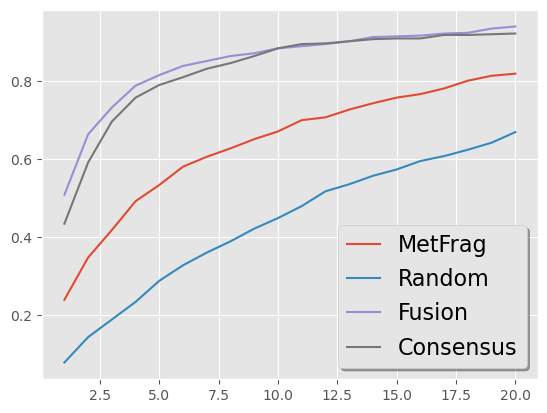

In [40]:
task = '29d517e67067476bae97a32f2d4977e0'
nap_result = Proteosafe(task, 'nap')
nap_result.get_nap()
net = nap_result.net
tabgnps = nap_result.tabgnps
sval = pd.merge(tabgnps[['cluster.index', 'parent.mass']],
                val.loc[val['Processing batch']==1, ['cluster.index',
                                                     'parent.mass', 'MetFrag',
                                                     'Random', 'Fusion',
                                                     'Consensus']],
                left_on='cluster.index', right_on='cluster.index')
sval.shape
cumlist = {'MetFrag':[], 'Random':[], 'Fusion':[], 'Consensus':[]}
total = sval.shape[0]
# labels got mixed during export of final table
for i in range(1, 21):
    cumlist['MetFrag'] = cumlist['MetFrag']+[sum(sval['MetFrag']<=i)/total]
    cumlist['Fusion'] = cumlist['Fusion']+[sum(sval['Random']<=i)/total]
    cumlist['Random'] = cumlist['Random']+[sum(sval['Consensus']<=i)/total]
    cumlist['Consensus'] = cumlist['Consensus']+[sum(sval['Fusion']<=i)/total]

for k,v in cumlist.items():
    plt.plot(range(1, 21), v)

plt.legend(list(cumlist.keys()),
           shadow=True, handlelength=1.5, fontsize=16)
plt.show()

How to find a result re-ranked by NAP.

In [31]:
lid = nap_result.lid
pd.DataFrame(lid[5]).head()
pd.DataFrame(lid[5])['InChIKey1']==val.loc[4, 'InChIKey Recovered'].split('-')[0]
np.where(pd.DataFrame(lid[5])['InChIKey1']==val.loc[4, 'InChIKey Recovered'].split('-')[0])
fusion = nap_result.fusion
np.where(pd.DataFrame(fusion[5]).sort_values(['fusion'], ascending=False)['InChIKey1']==val.loc[4, 'InChIKey Recovered'].split('-')[0])
tabgnps.head()

,cluster.index,number.of.spectra,parent.mass,precursor.charge,precursor.mass,sum.precursor.intensity.,G1,G2,G3,G4,...,RTStdErr,ProteoSAFeClusterLink,UniqueFileSourcesCount,EvenOdd,LibraryID,NumberOrganismIDs,AllOrganisms,SpectrumID,Smiles,INCHI
0,1,1,319.086,1,319.086,0,1,0,0,0,...,0,http://gnps.ucsd.edu//ProteoSAFe/result.jsp?ta...,1,1,"2-((4,6-Dimethyl-2-pyrimidinyl)thio)-N-(3-nitr...",1,PRIVATE-USER;,CCMSLIB00003153831,CC1=CC(=NC(=N1)SCC(=O)NC2=CC(=CC=C2)[N+](=O)[O...,InChI=1S/C14H14N4O3S/c1-9-6-10(2)16-14(15-9)22...
1,2,1,362.053,1,362.053,0,1,0,0,0,...,0,http://gnps.ucsd.edu//ProteoSAFe/result.jsp?ta...,1,0,N-(3-Nitrophenyl)-2-((4-methyl-5-(trifluoromet...,1,PRIVATE-USER;,CCMSLIB00003153832,CN1C(=NN=C1SCC(=O)NC2=CC(=CC=C2)[N+](=O)[O-])C...,"InChI=1S/C12H10F3N5O3S/c1-19-10(12(13,14)15)17..."
2,3,1,311.027,1,311.027,0,1,0,0,0,...,0,http://gnps.ucsd.edu//ProteoSAFe/result.jsp?ta...,1,1,"N-(3-Nitrophenyl)-2-((5-methyl-1,3,4-thiadiazo...",1,PRIVATE-USER;,CCMSLIB00003153833,CC1=NN=C(S1)SCC(=O)NC2=CC(=CC=C2)[N+](=O)[O-],InChI=1S/C11H10N4O3S2/c1-7-13-14-11(20-7)19-6-...
3,4,1,393.135,1,393.135,0,1,0,0,0,...,0,http://gnps.ucsd.edu//ProteoSAFe/result.jsp?ta...,1,1,NaN,0,NaN,NaN,NaN,NaN
4,5,1,310.216,1,310.216,0,1,0,0,0,...,0,http://gnps.ucsd.edu//ProteoSAFe/result.jsp?ta...,1,1,Methadone,1,PRIVATE-USER;,CCMSLIB00003153946,CCC(=O)C(CC(C)N(C)C)(C1=CC=CC=C1)C2=CC=CC=C2,InChI=1S/C21H27NO/c1-5-20(23)21(16-17(2)22(3)4...


Format the results from ChemWalker to plot results against NAP's.

In [68]:
fgs = df.fingerprint.unique()
fdf = []
for f in fgs:
    sval = pd.merge(df[df.fingerprint==f],
                    val.loc[val['Processing batch']==1, ['cluster.index',
                                                         'parent.mass', 'MetFrag',
                                                         'Random', 'Fusion',
                                                         'Consensus']],
                    left_on='cluster index', right_on='cluster.index')
    sval['metfrag'] += 1
    sval['rw'] += 1
    sval = sval[sval['metfrag']==sval['MetFrag']]
    print(sval.shape[0], 'for fingerprint', f)
    cumlist = {'MetFrag':[], 'Random':[], 'Fusion':[], 'Consensus':[], 'seed':[]}
    total = sval.shape[0]
    for i in range(1, 21):
        cumlist['MetFrag'] = cumlist['MetFrag']+[sum(sval['MetFrag']<=i)/total]
        cumlist['Fusion'] = cumlist['Fusion']+[sum(sval['Random']<=i)/total]
        cumlist['Random'] = cumlist['Random']+[sum(sval['Consensus']<=i)/total]
        cumlist['Consensus'] = cumlist['Consensus']+[sum(sval['Fusion']<=i)/total]
        cumlist['seed'] = cumlist['seed']+[sum(sval['rw']<=i)/total]
    tmp = pd.DataFrame(cumlist)
    tmp['fingerprint'] = f
    fdf.append(tmp)

fdf = pd.concat(fdf)

sval.rename(columns={'Random': 'Fusion', 'Consensus':'Random', 'Fusion':'Consensus'}, inplace=True)

461 for fingerprint AP-bits
461 for fingerprint RDKit5
461 for fingerprint MFP0-bits
461 for fingerprint FeatMFP1
461 for fingerprint RDKit6
461 for fingerprint FeatMFP0
461 for fingerprint RDKit5-linear
461 for fingerprint Avalon-512
461 for fingerprint RDKit7-linear
461 for fingerprint MFP3
461 for fingerprint FeatMFP2
461 for fingerprint RDKit4-linear
461 for fingerprint MFP2-bits
461 for fingerprint AP
461 for fingerprint Avalon-1024
461 for fingerprint MFP2
461 for fingerprint RDKit6-linear
461 for fingerprint RDKit7
461 for fingerprint RDKit4
461 for fingerprint TT-bits
461 for fingerprint MFP1
461 for fingerprint MFP0
461 for fingerprint FeatMFP3
461 for fingerprint MFP3-bits
461 for fingerprint MFP1-bits
461 for fingerprint MACCS
461 for fingerprint TT


Plot all results.

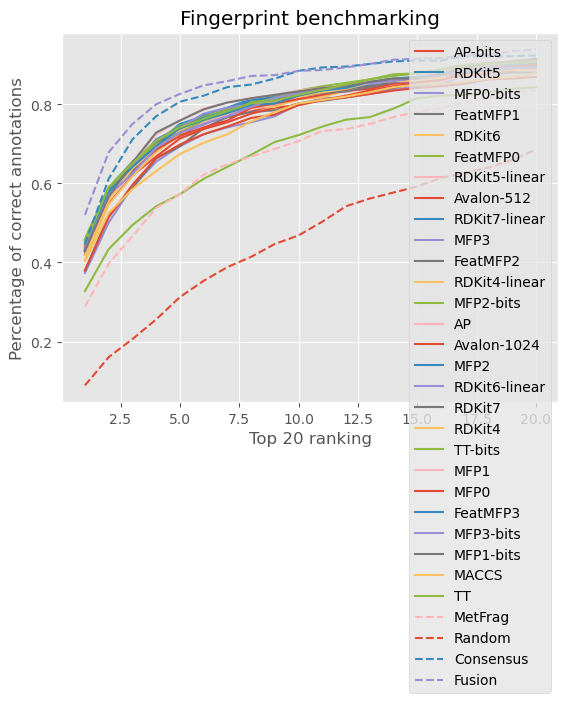

In [69]:
for f in fgs:
    plt.plot(range(1, 21), fdf.loc[fdf.fingerprint==f, 'seed'])


plt.plot(range(1, 21), fdf.loc[fdf.fingerprint==f, 'MetFrag'], linestyle='--')
plt.plot(range(1, 21), fdf.loc[fdf.fingerprint==f, 'Random'], linestyle='--')
plt.plot(range(1, 21), fdf.loc[fdf.fingerprint==f, 'Consensus'], linestyle='--')
plt.plot(range(1, 21), fdf.loc[fdf.fingerprint==f, 'Fusion'], linestyle='--')

plt.legend(fgs.tolist()+['MetFrag', 'Random', 'Consensus', 'Fusion'])
plt.title('Fingerprint benchmarking')
plt.xlabel('Top 20 ranking')
plt.ylabel('Percentage of correct annotations')
plt.show()

Select best performing fingerprints.

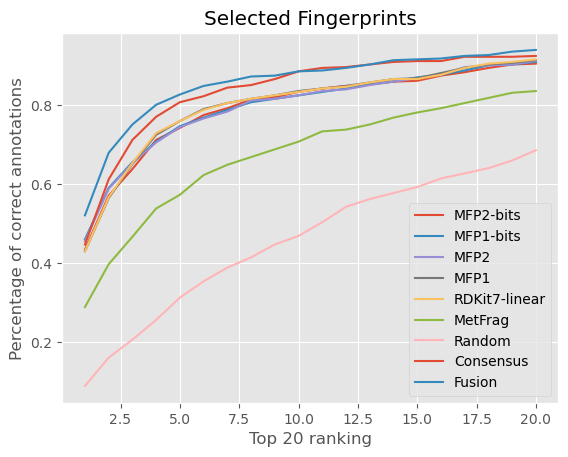

In [70]:
sel = ['MFP2-bits', 'MFP1-bits', 'MFP2', 'MFP1', 'RDKit7-linear']

for f in fgs:
    if f in sel:
        plt.plot(range(1, 21), fdf.loc[fdf.fingerprint==f, 'seed'])


plt.plot(range(1, 21), fdf.loc[fdf.fingerprint==f, 'MetFrag'])
plt.plot(range(1, 21), fdf.loc[fdf.fingerprint==f, 'Random'])
plt.plot(range(1, 21), fdf.loc[fdf.fingerprint==f, 'Consensus'])
plt.plot(range(1, 21), fdf.loc[fdf.fingerprint==f, 'Fusion'])

plt.legend(sel+['MetFrag', 'Random', 'Consensus', 'Fusion'])
plt.title('Selected Fingerprints')
plt.xlabel('Top 20 ranking')
plt.ylabel('Percentage of correct annotations')
plt.show()

In [71]:
sval.head()

,cluster index,metfrag,rw,comp,fingerprint,cluster.index,parent.mass,MetFrag,Fusion,Consensus,Random
1,461.0,9.0,9.0,52,TT,461,185.081,9,11,11,6
3,567.0,13.0,13.0,79,TT,567,279.102,13,13,13,20
5,579.0,1.0,1.0,89,TT,579,328.098,1,1,1,10
7,310.0,25.0,18.0,5,TT,310,243.076,25,24,25,6
8,317.0,2.0,3.0,5,TT,317,270.149,2,4,3,37


Compare best performing fingerprints to NAP.

In [75]:
sum(sval['rw']==1)

198

In [74]:
sval.rw.value_counts().sort_index()

1.0      198
2.0       63
3.0       40
4.0       35
5.0       14
6.0       13
7.0        8
8.0        5
9.0        4
10.0       4
11.0       4
12.0       2
13.0       5
14.0       4
16.0       5
17.0       8
18.0       5
19.0       2
20.0       3
21.0       1
22.0       3
23.0       2
24.0       2
26.0       1
27.0       3
28.0       1
29.0       1
30.0       2
33.0       2
34.0       2
36.0       2
37.0       1
39.0       2
43.0       1
53.0       1
56.0       1
62.0       1
68.0       1
69.0       1
74.0       1
76.0       1
80.0       2
82.0       2
84.0       1
201.0      1
Name: rw, dtype: int64

In [81]:
from scipy.stats import chi2_contingency

sval = pd.merge(df[df.fingerprint=='RDKit7-linear'],
                val.loc[val['Processing batch']==1, ['cluster.index',
                                                     'parent.mass', 'MetFrag',
                                                     'Random', 'Fusion',
                                                     'Consensus']],
                left_on='cluster index', right_on='cluster.index')
sval['metfrag'] += 1
sval['rw'] += 1
sval = sval[sval['metfrag']==sval['MetFrag']]
print(sval.shape[0], 'for fingerprint', 'RDKit7-linear')

sval.rename(columns={'Random': 'Fusion', 'Consensus':'Random', 'Fusion':'Consensus'}, inplace=True)

a = np.vstack((sval.Random.value_counts().sort_index().head(20), sval.rw.value_counts().sort_index().head(20)))
chi2, p, dof, expected = chi2_contingency(a)
print('Random-vs-RW', chi2, p)
a = np.vstack((sval.MetFrag.value_counts().sort_index().head(20), sval.rw.value_counts().sort_index().head(20)))
chi2, p, dof, expected = chi2_contingency(a)
print('MetFrag-vs-RW', chi2, p)
a = np.vstack((sval.Consensus.value_counts().sort_index().head(20), sval.rw.value_counts().sort_index().head(20)))
chi2, p, dof, expected = chi2_contingency(a)
print('Consensus-vs-RW', chi2, p)
a = np.vstack((sval.Fusion.value_counts().sort_index().head(20), sval.rw.value_counts().sort_index().head(20)))
chi2, p, dof, expected = chi2_contingency(a)
print('Fusion-vs-RW', chi2, p)

461 for fingerprint RDKit7-linear
Random-vs-RW 164.63996498653515 3.167682101231257e-25
MetFrag-vs-RW 33.412722962588006 0.02153329381080815
Consensus-vs-RW 19.538425062163608 0.42281781238895577
Fusion-vs-RW 19.880847905575163 0.4017798629899133
